--------------------------------------------
**All information in ths notebook is licensed under the BSD 3-Clause "New" or "Revised" License. The license is found [here](https://github.com/jGaboardi/non-duplicated-intersects/blob/master/LICENSE).**

**If any part of this notebook is used in your research, please cite with the reference found in [README.md](https://github.com/jGaboardi/non-duplicated-intersects/blob/master/README.md#bibtex-citation).**

--------------------------------------------
# Non-duplicated intersects
## Demonstrating an enhanced intersect operation with [sjoin in GeoPandas](http://geopandas.org/reference/geopandas.sjoin.html)
### Author: James D. Gaboardi jgaboardi@gmail.com
-----------------------------------
### This notebook demonstrates the strengths of combining the concepts of `within` and `intersects` for a non-duplicated `intersects` version of spatial join. This method can be thought of as "point-associated-with-polygon," because it captures the spatial relationship of points contained within a polygon **and** touching the exterior of the polygon, **while** preserving the cardinality of the original point set, $|P| = |P^\prime|$.

### Overview
1. #### Generating synthetic data
2. #### Demonstrating `within`
3. #### Demonstrating `intersects`
4. #### Demonstrating non-duplicated `intersects` (`nd-intersects`)

In [1]:
%load_ext watermark
%watermark

2020-01-22T00:59:41-05:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import geopandas
import matplotlib
import shapely
import string
from shapely.geometry import Point, Polygon
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina", quality=100)
except ImportError:
    pass
%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
geopandas  0.6.2
shapely    1.6.4.post2
matplotlib 3.1.2



----------------------------------------
## 1. Synthetic Data
### Synthetic points

In [3]:
point_coords = [(-1,-1), (0,-1), (.5,-.75), (-.5,-.5), (.5,-.5), (0,0), (.5,.5)]
point_ids = {"point_id":list(string.ascii_uppercase[:len(point_coords)])}
points = [Point(coords) for coords in point_coords]
points = geopandas.GeoDataFrame(point_ids, geometry=points)
points

,point_id,geometry
0,A,POINT (-1.00000 -1.00000)
1,B,POINT (0.00000 -1.00000)
2,C,POINT (0.50000 -0.75000)
3,D,POINT (-0.50000 -0.50000)
4,E,POINT (0.50000 -0.50000)
5,F,POINT (0.00000 0.00000)
6,G,POINT (0.50000 0.50000)


### Synthetic polygons

In [4]:
polygon_coords = [
    [(-1,-1), (0,-1), (0,0), (-1,0)],
    [(0,-1), (1,-1), (1,0), (0,0)],
    [(-1,0), (0,0), (0,1), (-1,1)]
]
polygons = [Polygon(coords) for coords in polygon_coords]
polygon_ids = {"polygon_id":list(string.ascii_lowercase[-len(polygon_coords):])}
polygons = geopandas.GeoDataFrame(polygon_ids, geometry=polygons)
polygons

,polygon_id,geometry
0,x,"POLYGON ((-1.00000 -1.00000, 0.00000 -1.00000,..."
1,y,"POLYGON ((0.00000 -1.00000, 1.00000 -1.00000, ..."
2,z,"POLYGON ((-1.00000 0.00000, 0.00000 0.00000, 0..."


----------------------------------------------------
## 2. Perform left spatial join — `within`
### The issue with a `within` operation is that a point that exactly intersects a polygon exterior (`touch`) is not contained in the polygon.

In [5]:
keep_columns = ["point_id", "polygon_id", "geometry"]
within_df = geopandas.sjoin(points, polygons, how="left", op="within")
within_df = within_df.copy()[keep_columns]
# Fill actual NaN with "NaN" for plotting purposes
within_df.loc[(within_df["polygon_id"].isna()), "polygon_id"] = "NaN"
within_df

,point_id,polygon_id,geometry
0,A,NaN,POINT (-1.00000 -1.00000)
1,B,NaN,POINT (0.00000 -1.00000)
2,C,y,POINT (0.50000 -0.75000)
3,D,x,POINT (-0.50000 -0.50000)
4,E,y,POINT (0.50000 -0.50000)
5,F,NaN,POINT (0.00000 0.00000)
6,G,NaN,POINT (0.50000 0.50000)


### Plot — `within`

In [6]:
def pgon_labels(pgons, b, pgid, geom="geometry"):
    """label polygons with 'polygon_id'"""
    def _loc(_x):
        """polygon label location helper"""
        return [coord+.35 for coord in _x[geom].centroid.coords[0]]
    kws = {"size":25, "va":"bottom"}
    pgons.apply(lambda x: b.annotate(s=x[pgid], xy=_loc(x), **kws), axis=1)

In [7]:
def pt_labels(pts, b, ptid, pgid, geom="geometry"):
    """label points with 'point_id+polygon_id'"""
    def _lab(_x):
        """point label helper"""
        return ",".join([_x[ptid], _x[pgid]])
    def _loc(_x):
        """point label location helper"""
        return _x[geom].coords[0]
    kws = {"size":15, "va":"bottom", "weight":"bold"}
    pts.apply(lambda x: b.annotate(s=_lab(x), xy=_loc(x), **kws), axis=1)

In [8]:
def title(label, sup=True):
    """add a suptitle or title"""
    if sup:
        matplotlib.pyplot.suptitle(label, x=0.515, y=.98, fontsize=30)
    else:
        matplotlib.pyplot.title(label, fontsize=20)

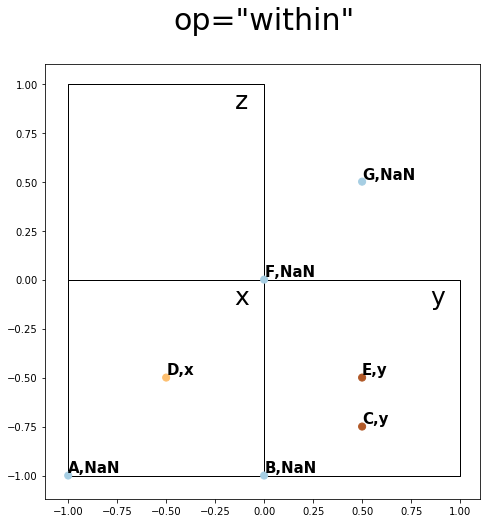

In [9]:
base = polygons.plot(figsize=(8,8), zorder=0, facecolor="w", edgecolor="k")
within_df.plot(ax=base, markersize=50, column="polygon_id", cmap="Paired")
# polygons labeled with "polygon_id"
pgon_labels(polygons, base, "polygon_id")
# points labeled with "point_id" and "polygon_id"
pt_labels(within_df, base, "point_id", "polygon_id")
# add title
title('op="within"');

-------------------------
## 3. Perform left spatial join — `intersects`
### The issue with an `intersects` operation is that a point that exactly intersects multiple polygon exteriors (`touch`) is duplicated from each polygon it intersects.

In [10]:
keep_columns = ["point_id", "polygon_id", "geometry"]
intersects_df = geopandas.sjoin(points, polygons, how="left", op="intersects")
intersects_df = intersects_df.copy()[keep_columns]
# Fill actual NaN with "NaN" for plotting purposes
intersects_df.loc[(intersects_df["polygon_id"].isna()), "polygon_id"] = "NaN"
intersects_df

,point_id,polygon_id,geometry
0,A,x,POINT (-1.00000 -1.00000)
1,B,x,POINT (0.00000 -1.00000)
1,B,y,POINT (0.00000 -1.00000)
2,C,y,POINT (0.50000 -0.75000)
3,D,x,POINT (-0.50000 -0.50000)
4,E,y,POINT (0.50000 -0.50000)
5,F,x,POINT (0.00000 0.00000)
5,F,y,POINT (0.00000 0.00000)
5,F,z,POINT (0.00000 0.00000)
6,G,NaN,POINT (0.50000 0.50000)


### Plot — `intersects`

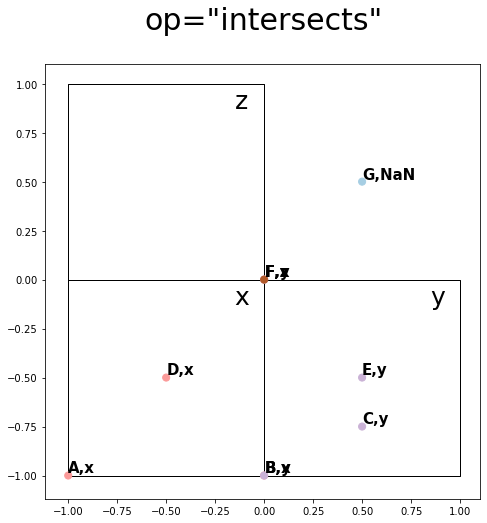

In [11]:
base = polygons.plot(figsize=(8,8), zorder=0, facecolor="w", edgecolor="k")
intersects_df.plot(ax=base, markersize=50, column="polygon_id", cmap="Paired")
# polygons labeled with "polygon_id"
pgon_labels(polygons, base, "polygon_id")
# points labeled with "point_id" and "polygon_id"
pt_labels(intersects_df, base, "point_id", "polygon_id")
# add title
title('op="intersects"');

-------------------------------------
## 4. Solution: a non-duplicated intersects operation
### This method has two benefits:
* #### polygon attribute values are squashed into one label, which can be extracted later; and
* #### the number of points in the original dataset is preserved

In [12]:
def nd_intersects(wgdf, igdf, ptid, pgid, nan="NaN", geom="geometry"):
    """Create a non-duplicated intersects geodataframe.
    
    Parameters
    ----------
    wgdf : geopandas.GeoDataFrame
        Result of the 'op="within"' spatial join.
    igdf : geopandas.GeoDataFrame
        Result of the 'op="intersects"' spatial join.
    ptid : str
        Point ID column name.
    pgid : str
        Polygon ID column name.
    nan : str
        No data (not a number) string representation. Default is 'NaN.'
    geom : str
        Geometry column name. Default is 'geometry.'
    
    Returns
    -------
    ndgdf : geopandas.GeoDataFrame
        Result of the non-duplicated intersects method.
    """
    
    # Isolate the cases of `intersect` but not `within`
    without = set(wgdf[(wgdf[pgid] == nan)].index)
    disjoint = set(igdf[(igdf[pgid] == nan)].index)
    touches = without.symmetric_difference(disjoint)
    
    # touches_df
    tgdf = igdf[igdf.index.isin(touches)]
    
    # Extract cases in touches from within_df for new within_df
    wgdf = igdf[~igdf.index.isin(touches)]
    
    # Squash touches_df by point_id and combine with within_df
    index = range(tgdf[ptid].nunique())
    _t_gdf = geopandas.GeoDataFrame(columns=tgdf.columns,index=index)
    
    # iterate over a grouby object to populate
    # the squashed touching points
    for idx, (pid, group) in enumerate(tgdf.groupby(ptid)):
        _t_gdf.loc[idx, ptid] = pid
        _t_gdf.loc[idx, pgid] = "-".join(group[pgid])
        _t_gdf.loc[idx, geom] = group[geom].unique()
    
    # append the squashed version of the
    # touching points the within points 
    ndgdf = wgdf.append(_t_gdf, ignore_index=True)
    
    return ndgdf

### Run the `nd-intersects ` method

In [13]:
nd_intersects_df = nd_intersects(within_df, intersects_df, "point_id", "polygon_id")
nd_intersects_df

,point_id,polygon_id,geometry
0,C,y,POINT (0.50000 -0.75000)
1,D,x,POINT (-0.50000 -0.50000)
2,E,y,POINT (0.50000 -0.50000)
3,G,NaN,POINT (0.50000 0.50000)
4,A,x,POINT (-1.00000 -1.00000)
5,B,x-y,POINT (0.00000 -1.00000)
6,F,x-y-z,POINT (0.00000 0.00000)


### Plot — `nd-intersects`

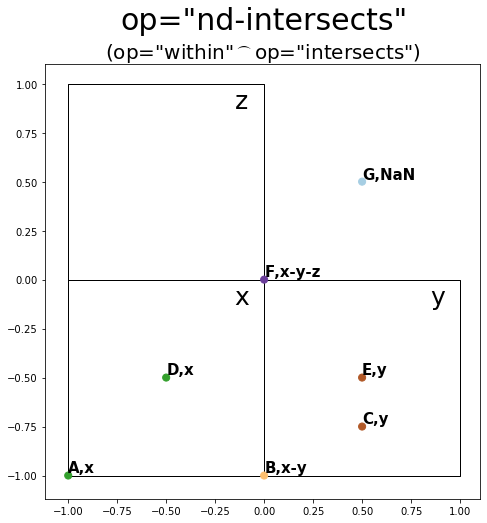

In [14]:
base = polygons.plot(figsize=(8,8), zorder=0, facecolor="w", edgecolor="k")
nd_intersects_df.plot(ax=base, markersize=50, column="polygon_id", cmap="Paired")
# polygons labeled with "polygon_id"
pgon_labels(polygons, base, "polygon_id")
# points labeled with "point_id" and "polygon_id"
pt_labels(nd_intersects_df, base, "point_id", "polygon_id")
# add title
title('op="nd-intersects"');
title('(op="within"$^\\frown$op="intersects")', sup=False);

------------------